<a href="https://colab.research.google.com/github/j2cry/gb_ds2_credit_default/blob/main/MirzoianP_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Время выполнения вычислений (as is) ~4 мин

In [165]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Prepare environment**

In [166]:
!pip install catboost

In [167]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from functools import partial
from scipy.stats import rv_discrete

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostClassifier, sum_models, to_classifier

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, KFold

PATH_TRAIN = '/content/drive/MyDrive/DS_part2/course_project_train.csv'
PATH_TEST = '/content/drive/MyDrive/DS_part2/course_project_test.csv'

In [168]:
import warnings
warnings.filterwarnings('ignore')

## Additional functions

In [169]:
def reduce_mem_usage(df, silent=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    if not silent:
      print(f'Memory usage of dataframe is {round(start_mem,2)} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    if not silent:
      print(f'Memory usage of dataframe is {round(end_mem,2)} MB')
      print(f'Decreased by {round(100 * (start_mem - end_mem) / start_mem,1 )}%')
    
    return df

# import train data
def load_dataset(path, with_index=None, silent=False):
  data = pd.read_csv(path, index_col=with_index)
  return reduce_mem_usage(data, silent)

In [170]:
def overview(field: str, **kwargs):
  """ kwargs:
        'zero'=True: add zero-line to plot
        'median'=True: add median to plot
        'mean'=True: add mean to plot
        'mode'=True: add mean to plot
        'bins'--> bins
  """
  size = kwargs.get('size') if kwargs.get('size') else (14, 4)
  fig, ax = plt.subplots(1, 2, figsize=size, gridspec_kw={'width_ratios': [.7, .3]})
  ax[0].plot(data[field].reset_index(drop=True))

  # set statistics
  stats = ['zero', 'median', 'mean', 'mode']
  for st in stats:
    if kwargs.get(st):
      func = getattr(data[field], st, lambda: 0)
      ax[0].plot(np.linspace(0, data.shape[0], 2), [func()] * 2, linewidth=1, label=st)
  # set legend
  if ax[0].get_legend_handles_labels()[1]:
    ax[0].legend()

  ax[0].set_xlabel('id')
  ax[0].set_ylabel(field)
  ax[0].set_title(f'`{field}` overview')
  if kwargs.get('ratata'):
    ax[0].tick_params(axis='x', rotation=kwargs.get('ratata'))


  if kwargs.get('bins'):
    ax[1].hist(data[field], bins=kwargs.get('bins'), density=True, ec='black')
  else:
    ax[1].hist(data[field], density=True, ec='black')
  ax[1].set_xlabel(field)
  ax[1].set_ylabel('Density')
  ax[1].set_title(f'`{field}` density')
  if kwargs.get('ratata'):
    ax[1].tick_params(axis='x', rotation=kwargs.get('ratata'))
  plt.show()
  print(f"Пропуски: {data.shape[0] - data[field].count()}")

In [171]:
def cat_overview(field):
  print(data[field].value_counts())
  print(f"Пропуски: {data.shape[0] - data[field].count()}")

# **Load dataset**

In [172]:
data = load_dataset(PATH_TRAIN)

Memory usage of dataframe is 0.97 MB
Memory usage of dataframe is 0.38 MB
Decreased by 60.9%


# **EDA**

In [173]:
target = 'Credit Default'

## Generals

In [174]:
data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [176]:
data.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


## Target

In [177]:
data['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

дисбаланс есть

## Home Ownership

In [178]:
cat_overview('Home Ownership')

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
Пропуски: 0


Пропусков нет. Поскольку значений "Have Mortgage" мало и они кажутся близкими к "Home Mortgage", их можно попробовать объединить в одну категорию

Можно считать, что: Own Home > Mortgage > Rent

## Annual Income

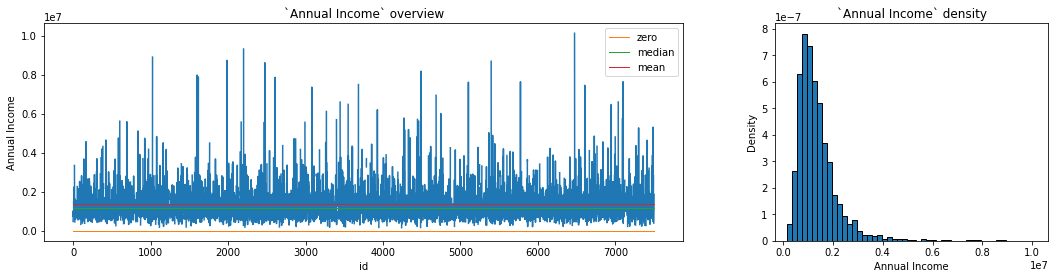

Пропуски: 1557


In [179]:
overview('Annual Income', size=(18, 4), bins=50, mean=True, median=True, zero=True)

Визуально вполне ок, но есть пропуски

## Years in current job

In [180]:
cat_overview('Years in current job')

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
Пропуски: 371


Перевести в вещественный признак. Также есть пропуски.

## Tax Liens

In [181]:
cat_overview('Tax Liens')

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
Пропуски: 0


Все ок

## Number of Open Accounts

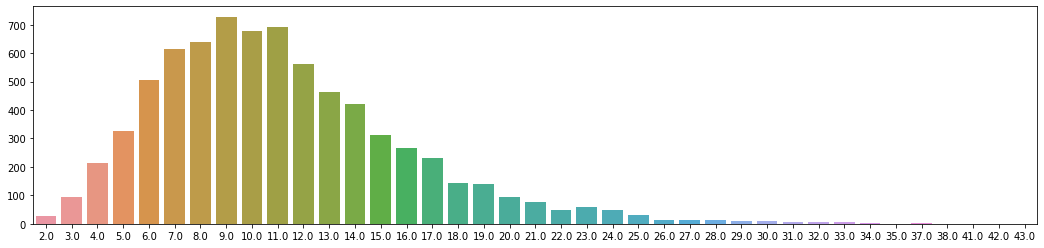

Пропуски: 0


In [182]:
plt.figure(figsize=(18, 4))
sns.barplot(data['Number of Open Accounts'].value_counts().index, data['Number of Open Accounts'].value_counts().values)
plt.show()
print(f"Пропуски: {data.shape[0] - data['Number of Open Accounts'].count()}")

Визуально ок, пропусков нет

## Years of Credit History

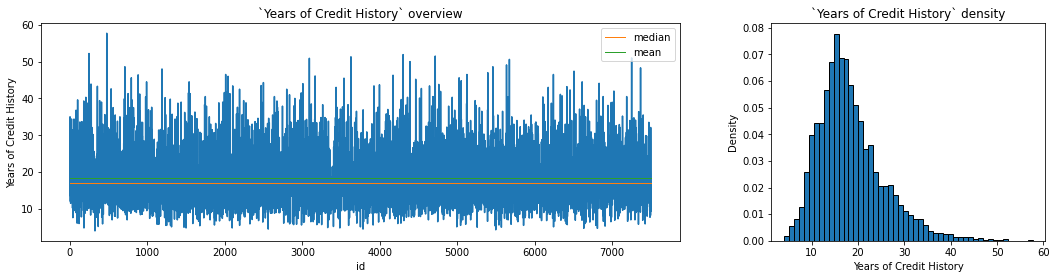

Пропуски: 0


In [183]:
overview('Years of Credit History', bins=50, size=(18, 4), median=True, mean=True)

Визуально ок, пропусков нет.

## Maximum Open Credit

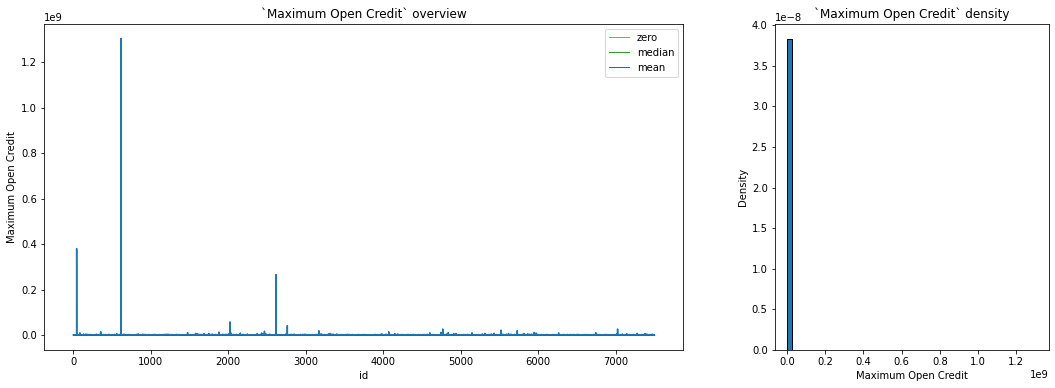

Пропуски: 0


In [184]:
overview('Maximum Open Credit', bins=50, size=(18, 6), median=True, mean=True, zero=True)

порядок 1e9 это может быть выброс, однако он не противоречит логике признака - вполне возможно, что у кого-то очень большой кредит был. А значения == 0, могут быть выбросы, если например Current Loan Amount != 0 или Monthly Debt != 0. Пропусков нет.

In [185]:
# пробую выкинуть и посмотреть, что получится
# data.drop(data.loc[data['Maximum Open Credit'] > 1e8, 'Maximum Open Credit'].index, inplace=True)

## Number of Credit Problems

In [186]:
cat_overview('Number of Credit Problems')

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64
Пропуски: 0


все ок

## Months since last delinquent

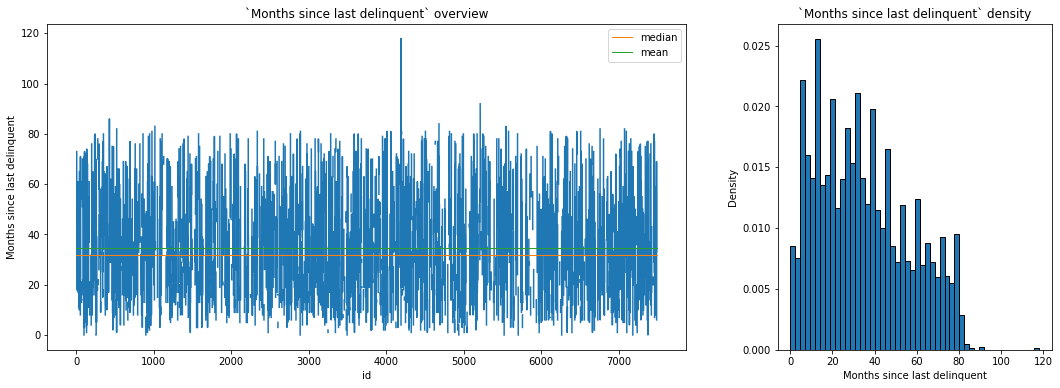

Пропуски: 4081


In [187]:
overview('Months since last delinquent', bins=50, size=(18, 6), median=True, mean=True)

Значения вполне ок, но больше половины данных - пропуски. Можно интерпретировать пропуск как факт отсутствия в прошлом просрочек по платежам (заполнить -1). Также попробовать другие варианты (заполнение медианой или с помощью модели)

## Bankruptcies

In [188]:
cat_overview('Bankruptcies')

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64
Пропуски: 14


Есть незначительное кол-во пропусков. Можно интерпретировать как отсутствие банкротств (заполнить нулями)

## Purpose

In [189]:
cat_overview('Purpose')

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
Пропуски: 0


Пропусков нет. Преобразовать в dummies, поэкспериментировать с разбиением на группы

## Term

In [190]:
cat_overview('Term')

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
Пропуски: 0


Пропусков нет. Бинарный признак - просто оцифровать

## Current Loan Amount

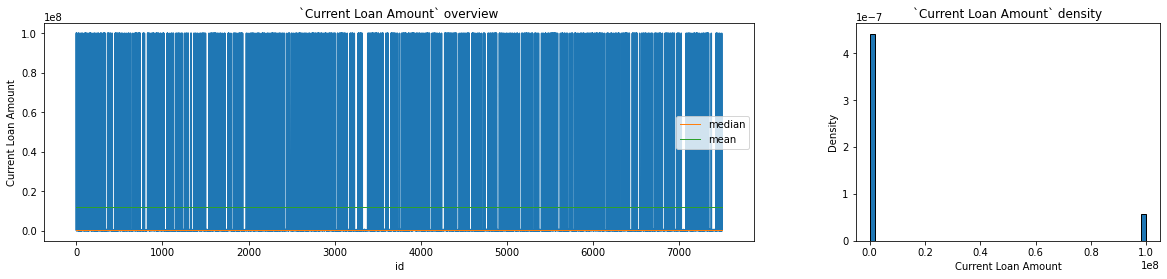

Пропуски: 0


In [191]:
overview('Current Loan Amount', bins=50, size=(20, 4), median=True, mean=True)

Пропусков нет. Порядок 1e8 - выбросы

In [192]:
# пробую выкинуть и посмотреть, что получится
# data.drop(data.loc[data['Current Loan Amount'] > 1e7, 'Current Loan Amount'].index, inplace=True)

## Current Credit Balance

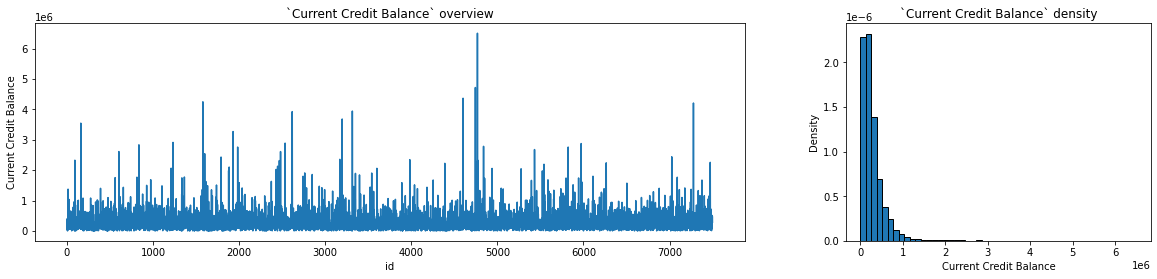

Пропуски: 0


In [193]:
overview('Current Credit Balance', bins=50, size=(20, 4))

Есть ряд выбивающихся значений, но логике признака они не противоречат

## Monthly Debt

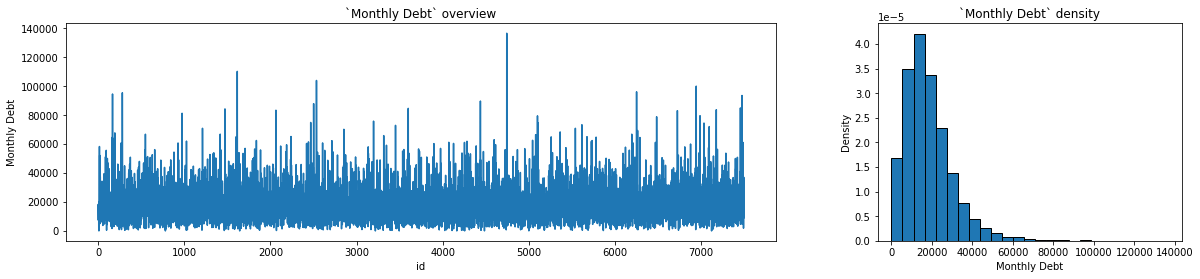

Пропуски: 0


In [194]:
overview('Monthly Debt', bins=25, size=(20, 4))

Пропусков нет. Визуально ок.

## Credit Score

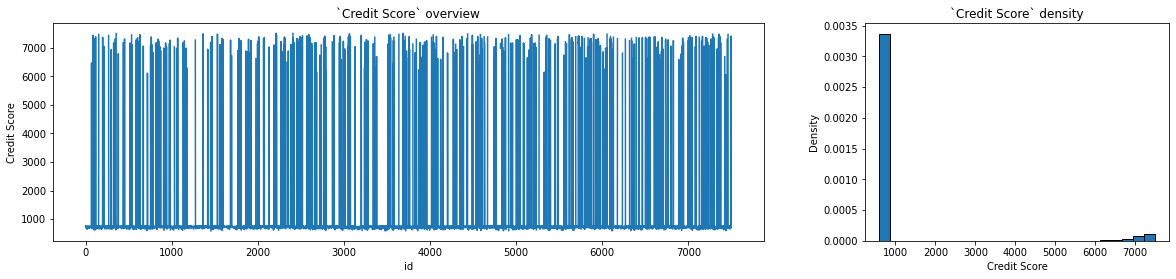

Пропуски: 1557
values > 1000: 400


In [195]:
overview('Credit Score', bins=25, size=(20, 4))
print(f"values > 1000: {data.loc[data['Credit Score'] > 1000, 'Credit Score'].count()}")

Есть значительное кол-во пропусков. и есть выыбросы: значения over 7k: их можно делить на 10

In [196]:
# пробую обработать и посмотреть, что получится
# data.drop(data.loc[data['Credit Score'] > 1000, 'Credit Score'].index, inplace=True)
# data.loc[data['Credit Score'] > 1000, 'Credit Score'] = data.loc[data['Credit Score'] > 1000, 'Credit Score'].apply(lambda value: value / 10)


## Logical validation of features

In [197]:
# ежемесячный платеж выше наибольшего открытого кредита - наверно, так быть не должно
data[data['Monthly Debt'] > data['Maximum Open Credit']].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0


In [198]:
# нулевой макс. кредит при указании месячного платежа - тоже ошибка в данных
data[(data['Maximum Open Credit'] == 0) & (data['Monthly Debt'] != 0)].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0


In [199]:
# нулевой ежемесячный платеж и нулевой макс. кредит
data[(data['Monthly Debt'] == 0) & (data['Maximum Open Credit'] == 0)].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
780,Home Mortgage,867749.0,10+ years,0.0,2.0,16.5,0.0,0.0,66.0,0.0,home improvements,Short Term,75350.0,0.0,0.0,704.0,0
1643,Rent,NaN,9 years,0.0,3.0,10.0,0.0,0.0,NaN,0.0,other,Short Term,332156.0,0.0,0.0,NaN,1
3219,Home Mortgage,NaN,10+ years,0.0,3.0,18.5,0.0,0.0,NaN,0.0,debt consolidation,Short Term,79200.0,0.0,0.0,NaN,0
3496,Rent,233567.0,1 year,0.0,7.0,11.7,0.0,0.0,0.0,NaN,educational expenses,Short Term,210166.0,0.0,0.0,746.0,0
4165,Rent,1254513.0,10+ years,0.0,6.0,23.4,0.0,0.0,60.0,0.0,take a trip,Short Term,100000000.0,0.0,0.0,748.0,0


Нулевой ежемесячный платеж и нулевой макс. кредит - вполне допустимо, НО<br>
Текущий долг (`Current Loan Amount`) при этом `!= 0`, плюс в одной записи есть `Credit Default == 1`, а значит значения `Monthly Debt == 0` и `Maximum Open Credit == 0`, скорее всего, некорретны

## Correlations

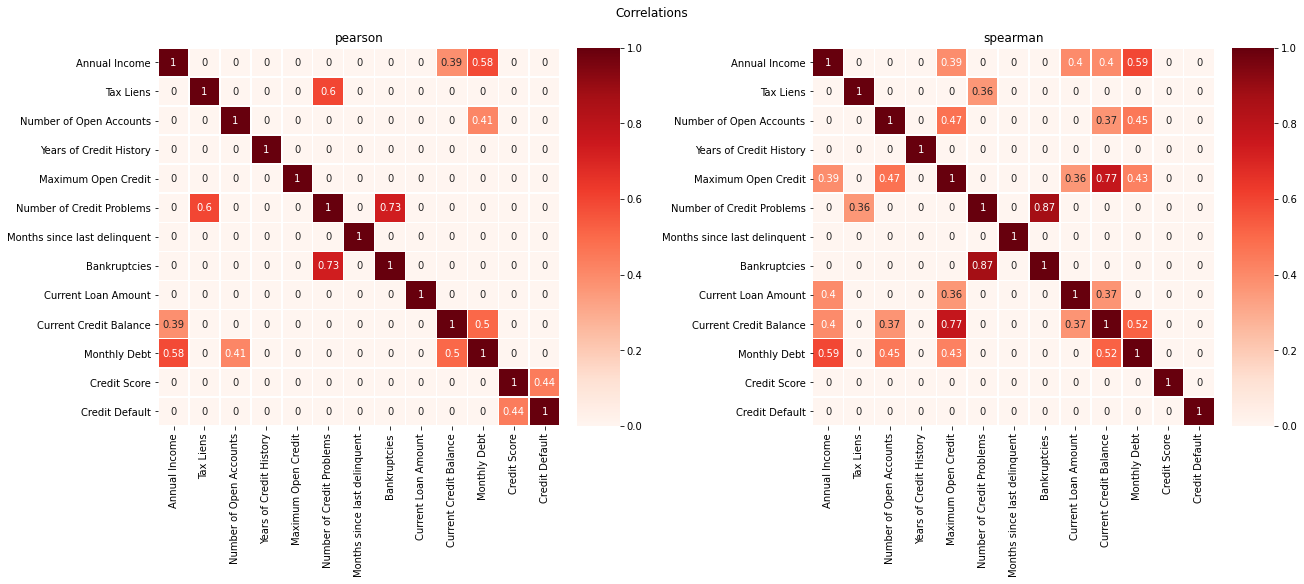

In [200]:
def correlation_matrix(*, threshold=None):
  methods = ['pearson', 'spearman']     # pearson/spearman/kendall
  fig, ax = plt.subplots(1, len(methods), figsize=(18, 8), constrained_layout=True)
  fig.suptitle('Correlations')

  for ind, mtd in enumerate(methods):
    corr = data.corr(mtd)
    if threshold:
      corr[abs(corr) < threshold] = 0
    sns.heatmap(corr, lw=0.5, cmap='Reds', annot=True, ax=ax[ind])
    ax[ind].set_title(mtd)
  plt.show()

correlation_matrix(threshold=0.35)

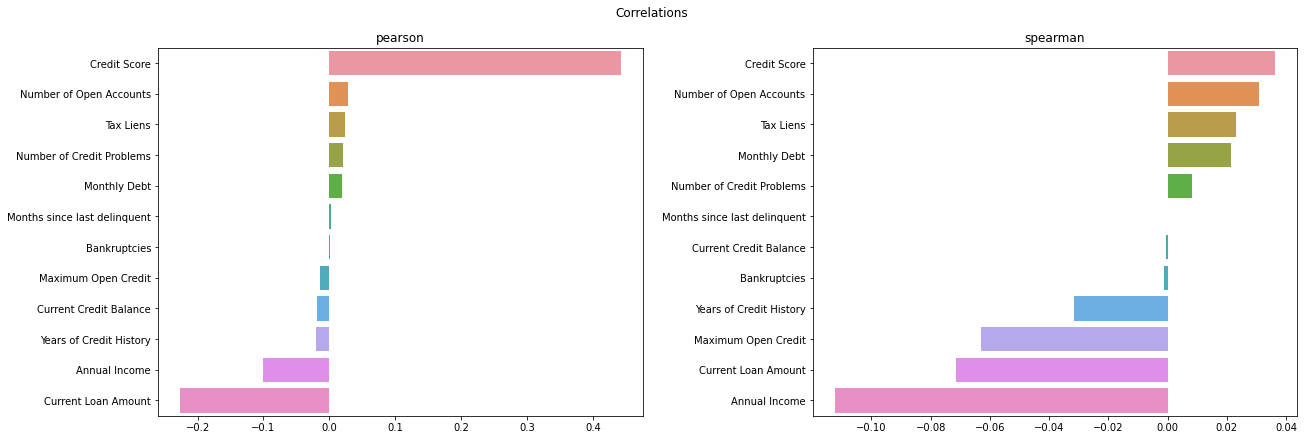

In [201]:
def correlations_target(target):
  methods = ['pearson', 'spearman']
  fig, ax = plt.subplots(1, len(methods), figsize=(18, 6), constrained_layout=True)
  fig.suptitle('Correlations')

  for ind, mtd in enumerate(methods):
    corr = data.corrwith(data[target], method=mtd).sort_values(ascending=False)
    corr.drop(target, inplace=True)
    sns.barplot(corr, corr.index, ax=ax[ind])
    ax[ind].set_title(mtd)
  plt.show()

correlations_target('Credit Default')

# **Data correction**

In [202]:
class Preprocessing:
  def __init__(self):
    self.home_ownership_encode = {'Home Mortgage': 0,
                                  'Have Mortgage': 0,
                                  'Rent': -1,
                                  'Own Home': 2}
    self.purpose_dict = {'debt consolidation': 0,
                         'other': 1,
                         'home improvements': 2,
                         'business loan': 3,
                         'buy a car': 4,
                         'medical bills': 5,
                         'major purchase': 6,
                         'take a trip': 7,
                         'buy house': 8,
                         'small business': 9,
                         'wedding': 10,
                         'moving': 11,
                         'educational expenses': 12,
                         'vacation': 13,
                         'renewable energy': 14,
                         }
    self.medians = None
    self.monthly_debt_by_purpose_medians = None
    self.loan_quantille = None


  def fill_outliers(self, X, feature: str, condition, method='None', value=0, repair_prefix='repaired'):
    """ Fills outliers by condition in column `feature` of dataframe X with selected method.
        If method is None or incorrect - fill with value.
        Also adds data-repaired flag """
    if repair_prefix:
      X[f'{repair_prefix} {feature}'] = 0
      X.loc[condition, f'{repair_prefix} {feature}'] = 1
    if method != 'model':
      try:
        func = getattr(X.loc[~condition, feature], method)
        X.loc[condition, feature] = func()
      except (AttributeError, TypeError):
        X.loc[condition, feature] = value
    else:   # modeling
      df = X.copy()

      df_X = df[~condition].drop(columns=feature)
      df_y = df.loc[~condition, feature]
      df_predict = df[condition].drop(columns=feature)
      X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, shuffle=True, random_state=47)

      fill_model = XGBRegressor(random_state=19,
                                subsample=0.1,
                                min_child_weight=10,
                                objective='reg:squarederror',
                                max_depth=5,
                                n_estimators=500,
                                learning_rate=0.1,)
      fill_model.fit(X_train, y_train)
      X.loc[condition, feature] = fill_model.predict(df_predict)


  def fillnan(self, X, feature: str, method='None', value=0, repair_prefix='repaired'):
    """ Fills NaN in column `feature` of dataframe X with value. Also adds data-repaired flag """
    self.fill_outliers(X, feature, X[feature].isna(), method, value, repair_prefix)


  def years_in_current_job_encode(self, value: str) -> int:
    """ Encoder for `Years in current job`. Returns 0 for '< 1 years' """
    result = re.search(r'< (\d*)|(\d*)', value)
    if result.group(1):
      return 0
    elif result.group(2):
      return result.group(2)


  def fit(self, X):
    self.medians = X.median()
    self.monthly_debt_by_purpose_medians = X.groupby(['Purpose'])['Monthly Debt'].agg('median').to_dict()

    self.credit_history_max_quantille = X['Years of Credit History'].quantile(0.95)
    self.loan_quantille = X['Current Loan Amount'].quantile(0.9)
    self.score_max = 751;
    self.score_min = 1
    # self.score_min = X['Credit Score'].min()


  def transform(self, X):
    # encode categories
    X['Home Ownership'] = X['Home Ownership'].replace(self.home_ownership_encode).astype('int8')
    X['Years in current job'] = X['Years in current job'].apply(self.years_in_current_job_encode).astype('float16')
    X['Purpose'] = X['Purpose'].map(self.purpose_dict).astype('int8')   # encode source Purpose
    X['Term'] = X['Term'].apply(lambda value: int(value == 'Short Term')).astype('int8')    # Short Term = 0; Long Term = 1;


    # fill NaN & outliers
    # self.fillnan(X, 'Annual Income', method='model')
    self.fillnan(X, 'Annual Income', value=self.medians['Annual Income'])
    self.fillnan(X, 'Years in current job', method='median')
    self.fillnan(X, 'Months since last delinquent', value=-1)
    self.fillnan(X, 'Bankruptcies', value=0)

    out_condition = X['Monthly Debt'] == 0
    X['repaired Monthly Debt'] = 0
    X.loc[out_condition, 'repaired Monthly Debt'] = 1
    X.loc[out_condition, 'Monthly Debt'] = X['Term'].map(self.monthly_debt_by_purpose_medians)
    # self.fill_outliers(X, 'Monthly Debt', out_condition, value=self.medians['Monthly Debt'])
    # self.fill_outliers(X, 'Monthly Debt', out_condition, method='model')

    out_condition = X['Credit Score'] > self.score_max
    X.loc[out_condition, 'Credit Score'].apply(lambda value: value / 10)
    self.fillnan(X, 'Credit Score', method='model')
    # X['Credit Score'].clip(lower=self.score_min, upper=self.score_max, inplace=True)
    # self.fillnan(X, 'Credit Score', value=self.medians['Credit Score'])

    out_condition = X['Current Loan Amount'] >= self.loan_quantille
    # self.fill_outliers(X, 'Current Loan Amount', out_condition, value=self.medians['Current Loan Amount'])
    self.fill_outliers(X, 'Current Loan Amount', out_condition, method='model')

    out_condition = X['Maximum Open Credit'] == 0
    X['repaired Maximum Open Credit'] = 0
    X.loc[out_condition, 'repaired Maximum Open Credit'] = 1
    X.loc[out_condition, 'Maximum Open Credit'] = X.loc[out_condition, 'Current Loan Amount']    
    # self.fill_outliers(X, 'Maximum Open Credit', out_condition, value=self.medians['Maximum Open Credit'])
    # self.fill_outliers(X, 'Maximum Open Credit', out_condition, method='model')

    # swap if Monthly Debt is more than Maximum Open Credit
    swap_condition = X['Monthly Debt'] > X['Maximum Open Credit']
    X['swapped Monthly Debt'] = 0
    X.loc[swap_condition, 'swapped Monthly Debt'] = 1
    X.loc[swap_condition, ['Monthly Debt', 'Maximum Open Credit']] = X.loc[swap_condition, ['Maximum Open Credit', 'Monthly Debt']].values

    X.fillna(self.medians, inplace=True)
    return X

# **Balancing classes**

In [203]:
# # Балансировка: рандомизация по распределению

# def balancing(X, y, **params):
#   """ ATTENTION! All data must be set to numeric """
#   ignored_cols = params.pop('ignored_cols', [])
#   ignored_prefix = params.pop('ignored_prefix', [])
#   frac = params.pop('frac', 1)    # multiplier for items_counts

#   # disbalance = df[target].value_counts()[0] / df[target].value_counts()[1]
#   target = y.name
#   col_names = X.columns.to_list()
#   col_names.append(target)

#   # collect ignored columns: these will not be filled in
#   ignored = [col for col in X.columns if any([col.startswith(prefix) for prefix in ignored_prefix])]
#   ignored.extend(ignored_cols)

#   max_count = y.value_counts()[y.value_counts().argmax()]
#   ext_df = pd.DataFrame(columns=col_names, dtype='float64')

#   # for each class that differs from target
#   for cls, count in y.value_counts().items():
#     if count == max_count:
#       continue

#     # create zero dataframe
#     items_count = int((max_count - count) * frac)
#     cls_ext_df = pd.DataFrame(np.zeros(shape=(items_count, X.shape[1] + 1)), columns=col_names)
#     cls_ext_df[target] = cls

#     # fill features
#     for feat in X.columns:
#       if feat in ignored:
#         continue
#       # generate custom distribution
#       xk = X[feat].value_counts().keys().tolist()
#       pk = X[feat].value_counts().values / X.loc[X[feat].notna(), feat].shape[0]

#       rv = rv_discrete(name='custom', values=(xk, pk), seed=47)
#       cls_ext_df[feat] = rv.rvs(size=items_count, random_state=14)

#     ext_df = ext_df.append(cls_ext_df, ignore_index=True)      

#   return ext_df.drop(columns=[target]), ext_df[target]

In [204]:
# Балансировка: копирование объектов

def balancing(X, y, **params):
  frac = params.pop('frac', 1)    # multiplier for items_counts

  df = X.copy()
  df[y.name] = y

  max_count = y.value_counts()[y.value_counts().argmax()]
  ext_df = pd.DataFrame(columns=df.columns, dtype='float64')

  # for each class that differs from target
  for cls, count in y.value_counts().items():
    if count == max_count:
      continue
    
    # duplicate some values
    items_count = int((max_count - count) * frac)
    cls_ext_df = df.loc[y == cls].sample(items_count, random_state=77, replace=True)    
    ext_df = ext_df.append(cls_ext_df, ignore_index=True)      

  return ext_df.drop(columns=[y.name]), ext_df[y.name]

# **Featuring**

In [205]:
class Featuring:
  def __init__(self):
    self.group_feats = []
    self.medians = None

    self.default_by_purpose = None
    self.default_by_purpose_mode = None
    self.mode_score_default = None

    self.purposes_count = 15
    self.loan_by_purpose = None
    self.loan_by_term_purpose = None

  def fit(self, X, y=None):
    df = X.copy()
    self.medians = X.median()

    # ---------- FEATURES ACCORDIG TO TARGET AGGREGATE ----------
    if y is not None:
      df['Credit Default'] = y.values

      # Credit Default by Purpose aggregate
      self.default_by_purpose = df.groupby(['Purpose'])['Credit Default'].agg(lambda v: pd.Series.mode(v)[0]).to_dict()

      # Credit Score mode for Credit Default == 1 aggregate
      self.mode_score_default = df.groupby(['Credit Default'])['Credit Score'].agg(lambda v: pd.Series.mode(v)[0])[1]

    # ---------- GROUP FEATURES AGGREGATE ----------
    self.group_feats.extend([('Current Loan Amount', ['Term', 'Purpose']),
                             ('Annual Income', ['Years in current job', 'Home Ownership']),                             
                             ('Maximum Open Credit', ['Years in current job', 'Home Ownership']),
                            #  ('', ['']),
                            #  ('', ['']),
                            #  ('', ['']),
                             ])
    for mfeat, gfeat in self.group_feats:
      feat = X.groupby(gfeat)[mfeat].agg('median')
      feat_name = f'Median {mfeat} by {" and ".join(gfeat)}'
      setattr(self, feat_name.replace(' ', '_'), feat)


  def transform(self, X):
    # X['Purpose is debt consolidation'] = X['Purpose'].apply(lambda value: int(value == 'debt consolidation'))     # Purpose dummy

    categories = [f'One Hot Purpose {num}' for num in np.arange(0, self.purposes_count)]
    purpose_dummies = pd.get_dummies(X['Purpose'], prefix='One Hot Purpose', prefix_sep=' ')
    purpose_dummies = purpose_dummies.T.reindex(categories).T.fillna(0)
    X = X.join(purpose_dummies)

    # ---------- FEATURES ACCORDIG TO TARGET MERGE ----------
    # Credit Default by Purpose merge
    if self.default_by_purpose is not None:
      X['Default by Purpose'] = X['Purpose'].map(self.default_by_purpose)
    
    # Credit Score delta (minus mode for Credit Default)
    if self.mode_score_default is not None:
      X['Delta Credit Score'] = X['Credit Score'] - self.mode_score_default

    # ---------- GROUP FEATURES MERGE ----------
    for mfeat, gfeat in self.group_feats:
      feat_name = f'Median {mfeat} by {" and ".join(gfeat)}'
      feat = getattr(self, feat_name.replace(' ', '_'), None)
      if feat is not None:
        X[feat_name] = X[gfeat].join(feat, on=gfeat)[mfeat]

    # ---------- FEATURES ----------
    # Ожидаемый срок погашения
    # X['Expected Term'] = X['Current Loan Amount'] / X['Monthly Debt']

    # Monthly Income to Monthly Debt ratio: Количество платежей, обеспеченных годовым доходом
    max_payment_frac = 0.7    # макс. доля заработка, которую можно тратить на погашение долга
    X['Secured payments'] = (max_payment_frac * X['Annual Income']) / (X['Monthly Debt'] * 12)

    # Current Loan Amount to Monthly Income ratio: минимально возможный срок погашения
    X['Minimal possible Term'] = X['Current Loan Amount'] / (X['Annual Income']/12)

    # Maximum Open Credit to Annual Income medians ratio
    if ('Median Annual Income by Years in current job and Home Ownership' in X.columns) and \
       ('Median Maximum Open Credit by Years in current job and Home Ownership' in X.columns):
      X['Medians ratio: Maximum Open Credit to Annual Income (by Years in current job and Home Ownership)'] = X['Median Maximum Open Credit by Years in current job and Home Ownership'] / X['Median Annual Income by Years in current job and Home Ownership']
    
    # теоретический срок погашения среднего долга по аналогичной цели при текущем заработке
    if 'Median Current Loan Amount by Term and Purpose' in X.columns:
      X['Term for avg Loan by Purpose'] = X['Median Current Loan Amount by Term and Purpose'] / (max_payment_frac * X['Annual Income'] / 12)
      # отношение среднего долга по сроку и целям к макс. кредиту 
      X['Median Loan by term & purpose to Max Credit'] = X['Median Current Loan Amount by Term and Purpose'] / X['Maximum Open Credit']
      
      # отношение среднего долга по сроку и целям к среднему доходу по сроку работы и домовладдению
      if 'Median Annual Income by Years in current job and Home Ownership' in X.columns:
        X['Median Loan by term & purpose to median income by years in job & ownership'] = X['Median Current Loan Amount by Term and Purpose'] / X['Median Annual Income by Years in current job and Home Ownership']

    # Maximum Open Credit to Annual Income ratio
    X['Max Credit ratio'] = X['Annual Income'] / (X['Maximum Open Credit'] + X['Annual Income'])

    # ---------- SCALE FEATURES ----------
    # scaler
    scaled_feats = ['Tax Liens', 'Number of Credit Problems', 'Bankruptcies']
    rscaler = RobustScaler()
    pca = PCA(n_components=1, random_state=32)
    scaled = pd.DataFrame(rscaler.fit_transform(X[scaled_feats]))
    X['Scaled Problems'] = pca.fit_transform(scaled)

    # ---------- DROP COLUMNS AND FILL NA ----------

    drop_columns = ['Purpose', 'Median Annual Income by Years in current job and Home Ownership', 
                    'Median Maximum Open Credit by Years in current job and Home Ownership'] + scaled_feats + [f'repaired {f}' for f in scaled_feats]
    X.drop(columns=drop_columns, inplace=True, errors='ignore')
    X.fillna(self.medians, inplace=True)

    return X

# **Prepare datasets**

In [206]:
def prepare_data(X_train_src, y_train_src, X_test_src=None, **params):
  balance = params.pop('balance', None)

  X_train = X_train_src.copy()
  y_train = y_train_src.copy()
  if X_test_src is not None:
    X_test = X_test_src.copy()

  # Preprocessing
  preprocessor = Preprocessing()
  preprocessor.fit(X_train)
  X_train = preprocessor.transform(X_train)
  if X_test_src is not None:
    X_test = preprocessor.transform(X_test)

  # Balancing
  if balance:
    X_ext, y_ext = balancing(X_train, y_train, frac=balance)
    X_train = X_train.append(X_ext, ignore_index=True)
    y_train = y_train.append(y_ext, ignore_index=True)

  # Featuring
  featuring = Featuring()
  featuring.fit(X_train, y_train)
  X_train = featuring.transform(X_train)
  if X_test_src is not None:
    X_test = featuring.transform(X_test)

  disbalance = int(y_train.value_counts()[0]) / int(y_train.value_counts()[1])
  # print(f'disbalance: {disbalance}')
  
  return (X_train, y_train, X_test, disbalance) if X_test_src is not None else (X_train, y_train, disbalance)



# **Build classification model**

In [207]:
def fit_model(modelclass, X_train, y_train, X_test=None, y_test=None,  **params):
  """ Train one model of given class """
  if modelclass is CatBoostClassifier:
    model = CatBoostClassifier(logging_level='Silent',
                               allow_writing_files=False,
                               use_best_model=True,
                               eval_metric='F1',                               
                               custom_metric=['F1', 'Precision', 'Recall'],
                               **params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
  else:
    model = modelclass(**params)
    model.fit(X_train, y_train)
  return model


def make_model(**params):
  """ Make CatBoostClassifier models """
  # params  description
  runmode = params.pop('mode', 'cross')         # building model mode: 'single' - return one-time trained model, 'cross' - return sum of single models (amount is set by `folds`), 'both' - return both models
  balance = params.pop('balance', None)         # additional fraction of generated records combined with train data
  folds = params.pop('folds', 2)                # data folds (= number of models to be built and combined). Learn in non-cross mode if None
  cvfrac = params.pop('cvfrac', 0.2)            # fraction of the main dataset that is separated for final hold-out validation
  silent = params.pop('silent', False)          # don't print anything except the result
  split_rs = params.pop('split_rs', None)       # random state for dataset splitting
  model_rs = params.pop('model_rs', None)       # random state for modeling

  # load dataset
  df_train = load_dataset(PATH_TRAIN, silent=silent)

  X = df_train.drop(columns='Credit Default')
  y = df_train['Credit Default']

  # prepare whole train df for additional validation
  X_whole, y_whole, _ = prepare_data(X, y)
  # get part of the main dataset for final hold-out validation
  X, X_test_final, y, y_test_final = train_test_split(X, y, test_size=cvfrac, shuffle=True, random_state=split_rs)
  X_train_final, y_train_final, X_test_final, _ = prepare_data(X, y, X_test_final)

  # initialize some vars
  singlemodel, crossmodel = None, None
  model_sum = None
  models = []
  models_weights = []

  # init metrics
  metric_cols = ['single whole', 'single train', 'single test', 'cross whole', 'cross train', 'cross test']
  precision = [np.nan,] * len(metric_cols)
  recall = [np.nan,] * len(metric_cols)
  f1 = [np.nan,] * len(metric_cols)

  # train model(s)
  # ---------- cross model ----------
  if (runmode == 'cross') or (runmode == 'both'):   # cross-mode
    kf = KFold(n_splits=folds, shuffle=True, random_state=37)
    for num, (train_index, test_index) in enumerate(kf.split(X), 1):
      X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
      y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
    
      X_train, y_train, X_test, disbalance = prepare_data(X_train, y_train, X_test, balance=balance)
      crossmodel = fit_model(CatBoostClassifier, X_train, y_train, X_test, y_test,
                             random_state=model_rs,
                             class_weights=[1, disbalance],
                             **params)
      models.append(crossmodel)
      models_weights.append(f1_score(y_test, crossmodel.predict(X_test)))  # metric for models weights calc

    # set model weights by F1 test metric
    models_weights = np.array(models_weights)
    models_weights = models_weights / np.sum(models_weights)
    # models_weights = [1/len(models)] * len(models)
    if not silent:
      print(f'Built models amount: {len(models)}; weights of each model: {models_weights}\n  You can get list with models by `make_model.models`')

    # combine models (result is the same as step-learning model)
    crossmodel = to_classifier(sum_models(models, weights=models_weights))

    # final scoring
    precision[3] = precision_score(y_whole, crossmodel.predict(X_whole))
    precision[4] = precision_score(y_train_final, crossmodel.predict(X_train_final))
    precision[5] = precision_score(y_test_final, crossmodel.predict(X_test_final))
    recall[3] = recall_score(y_whole, crossmodel.predict(X_whole))
    recall[4] = recall_score(y_train_final, crossmodel.predict(X_train_final))
    recall[5] = recall_score(y_test_final, crossmodel.predict(X_test_final))
    f1[3] = f1_score(y_whole, crossmodel.predict(X_whole))
    f1[4] = f1_score(y_train_final, crossmodel.predict(X_train_final))
    f1[5] = f1_score(y_test_final, crossmodel.predict(X_test_final))

  # ---------- single model ---------
  if (runmode == 'single') or (runmode == 'both'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=37)
    X_train, y_train, X_test, disbalance = prepare_data(X_train, y_train, X_test, balance=balance)
    singlemodel = fit_model(CatBoostClassifier, X_train, y_train, X_test, y_test,
                            random_state=model_rs,
                            class_weights=[1, disbalance],
                            **params)

    # scoring
    precision[0] = precision_score(y_whole, singlemodel.predict(X_whole))
    precision[1] = precision_score(y_train, singlemodel.predict(X_train))
    precision[2] = precision_score(y_test_final, singlemodel.predict(X_test_final))
    recall[0] = recall_score(y_whole, singlemodel.predict(X_whole))
    recall[1] = recall_score(y_train, singlemodel.predict(X_train))
    recall[2] = recall_score(y_test_final, singlemodel.predict(X_test_final))
    f1[0] = f1_score(y_whole, singlemodel.predict(X_whole))
    f1[1] = f1_score(y_train, singlemodel.predict(X_train))
    f1[2] = f1_score(y_test_final, singlemodel.predict(X_test_final))

  setattr(make_model, 'models',  models)    # models on each fold in cross-modeling
  setattr(make_model, 'feat_names', X_train_final.columns)     # used features names
  setattr(make_model, 'precision', pd.Series(precision, index=metric_cols).dropna())
  setattr(make_model, 'recall', pd.Series(recall, index=metric_cols).dropna())
  setattr(make_model, 'f1', pd.Series(f1, index=metric_cols).dropna())
  
  returndict = {'single': singlemodel,
                'cross': crossmodel,
                'both': (singlemodel, crossmodel)}
  
  return returndict.get(runmode, None)

# **GridSearchCV**

In [208]:
# %%time
# # load and split dataset
# train_df = load_dataset(PATH_TRAIN)

# X = train_df.drop(columns='Credit Default')
# y = train_df['Credit Default']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=51)
# X_train, y_train, X_test, disbalance = prepare_data(X_train, y_train, X_test, balance=0.33)

# def_params = {'logging_level': 'Silent',
#               'allow_writing_files': False,
#               'use_best_model': True,
#               'eval_metric': 'F1',
#               # 'custom_metric': ['Precision', 'Recall'],
#               'class_weights': [1, disbalance],
#               'random_state': 986,
#           }

# params = {'learning_rate': [0.025, 0.075, 0.05, 0.1, 0.2, 0.3],
#           # 'bootstrap_type': ['MVS', 'Bayesian'],
#           'n_estimators': [100, 200, 300],
#           'max_depth': [4, 5, 6],
#           'l2_leaf_reg': [2.5, 3, 3.5, 3.75],
#           }

# model = CatBoostClassifier(**def_params)
# search = GridSearchCV(estimator=model,
#                       param_grid=params,
#                       scoring='f1',
#                       cv=KFold(n_splits=3, shuffle=True, random_state=15),
#                       n_jobs=-1)
# search.fit(X_train, y_train, eval_set=(X_test, y_test))

In [209]:
# print(search.best_params_)

# **Validation**

In [210]:
# Set `model_rs` if need to train model with different random-states splitting and whole train data validation
# Set `split_rs` if need to train models with different modeling random-states and whole train data validation
def validation(**params):
  count = params.pop('count', 10)
  model_rs = params.pop('model_rs', None)
  split_rs = params.pop('split_rs', None)

  cols = ['single whole', 'single train', 'single test', 'cross whole', 'cross train', 'cross test']
  f1 = pd.DataFrame(columns=cols)
  precision = pd.DataFrame(columns=cols)
  recall = pd.DataFrame(columns=cols)

  rng = np.random.default_rng()
  for i in range(count):
    rs = rng.integers(1000, endpoint=True)
    model = make_model(model_rs=model_rs if model_rs else rs,
                       split_rs=split_rs if split_rs else rs,
                       silent=True,
                       **params)
    make_model.f1.name = rs
    make_model.precision.name = rs
    make_model.recall.name = rs
    f1 = f1.append(make_model.f1)
    precision = precision.append(make_model.precision)
    recall = recall.append(make_model.recall)

  setattr(validation, 'f1', f1)
  setattr(validation, 'precision', precision)
  setattr(validation, 'recall', recall)

  stat = pd.DataFrame(columns=cols)
  stat = stat.append(pd.Series(f1.mean(), index=cols, name='F1 mean'))
  stat = stat.append(pd.Series(f1.var(), index=cols, name='F1 var'))
  stat = stat.append(pd.Series(f1.std(), index=cols, name='F1 std'))

  stat = stat.append(pd.Series(precision.mean(), index=cols, name='precision mean'))
  stat = stat.append(pd.Series(precision.var(), index=cols, name='precision var'))
  stat = stat.append(pd.Series(precision.std(), index=cols, name='precision std'))

  stat = stat.append(pd.Series(recall.mean(), index=cols, name='recall mean'))
  stat = stat.append(pd.Series(recall.var(), index=cols, name='recall var'))
  stat = stat.append(pd.Series(recall.std(), index=cols, name='recall std'))
  return stat.dropna(axis=1, how='all')

# **Output**

## Set parameters

In [211]:
# базовые параметры модели
base_params = {'cvfrac': 0.2,     # доля объектов из тренировочного датасета, выделяемая на итоговую hold-out валидацию
               'folds': 4,        # кол-во фолдов для кросс-обучения модели
               'balance': 0.15,   # доля дисбаланса классов, компенсируемого с помощью алгоритма (1 = дисбаланс будет компенсирован полностью)
               }

`cvfrac` и `folds` подобраны так, чтобы на тест уходило всегда одинаковое кол-во объектов (по 1500). Т.о. одномоментно в обучении участвует 4500 объектов и 6000 объектов всего.

In [212]:
hparams = {'learning_rate': 0.03,
           'max_depth': 5,
           'n_estimators': 300,
           'l2_leaf_reg': 3.15,
           }

## Checking the stability of model

In [213]:
# проверка устойчивости модели на разных сплитах: D -> 0, чем ниже дисперсия, тем стабильнее модель
validation(count=5,
           mode='both',
           model_rs=986,      # random_state для обучения модели
           **base_params,
           **hparams)

,single whole,single train,single test,cross whole,cross train,cross test
F1 mean,0.580106,0.649074,0.544525,0.588561,0.603092,0.543971
F1 var,0.000259,0.000888,0.000827,0.000080,0.000179,0.000657
F1 std,0.016104,0.029803,0.028752,0.008950,0.013364,0.025623
precision mean,0.523509,0.610288,0.490861,0.534672,0.547272,0.494062
precision var,0.000628,0.000678,0.001031,0.000117,0.000138,0.000745
precision std,0.025069,0.026039,0.032106,0.010822,0.011749,0.027299
recall mean,0.652059,0.693376,0.613756,0.654851,0.671915,0.605936
recall var,0.000636,0.001356,0.002001,0.000245,0.000478,0.001075
recall std,0.025216,0.036821,0.044734,0.015665,0.021859,0.032786


In [ ]:
# validation.f1

По целевой метрике F1 на тесте суммарная модель чуть лучше одинарной: целевые метрики практически одинаковы, но дисперсия на разных обучающих данных меньше у суммарной модели.<br>
*Объективно, 5 наблюдений недостаточно для адекватной оценки, поэтому я проводил оценку на 75 наблюдениях, однако в финальной версии уменьшил до 5 в целях сокращения времени вычислений.*

## Train final model

In [215]:
model = make_model(mode='cross',
                   split_rs=811,      # random_state для разделения датасета на train и финальный hold-out
                   model_rs=986,     # random_state для обучения модели
                   **base_params,
                   **hparams)

print('F1', make_model.f1, '', sep='\n')
print('Precision', make_model.precision, '', sep='\n')
print('Recall', make_model.recall, sep='\n')
print(make_model.f1['cross train'] - make_model.f1['cross test'])


Memory usage of dataframe is 0.97 MB
Memory usage of dataframe is 0.38 MB
Decreased by 60.9%
Built models amount: 4; weights of each model: [0.23572642 0.25537899 0.25634489 0.2525497 ]
  You can get list with models by `make_model.models`
F1
cross whole    0.588865
cross train    0.590278
cross test     0.571429
dtype: float64

Precision
cross whole    0.537740
cross train    0.532017
cross test     0.537549
dtype: float64

Recall
cross whole    0.650734
cross train    0.662867
cross test     0.609865
dtype: float64
0.018849206349206393


## Features importances

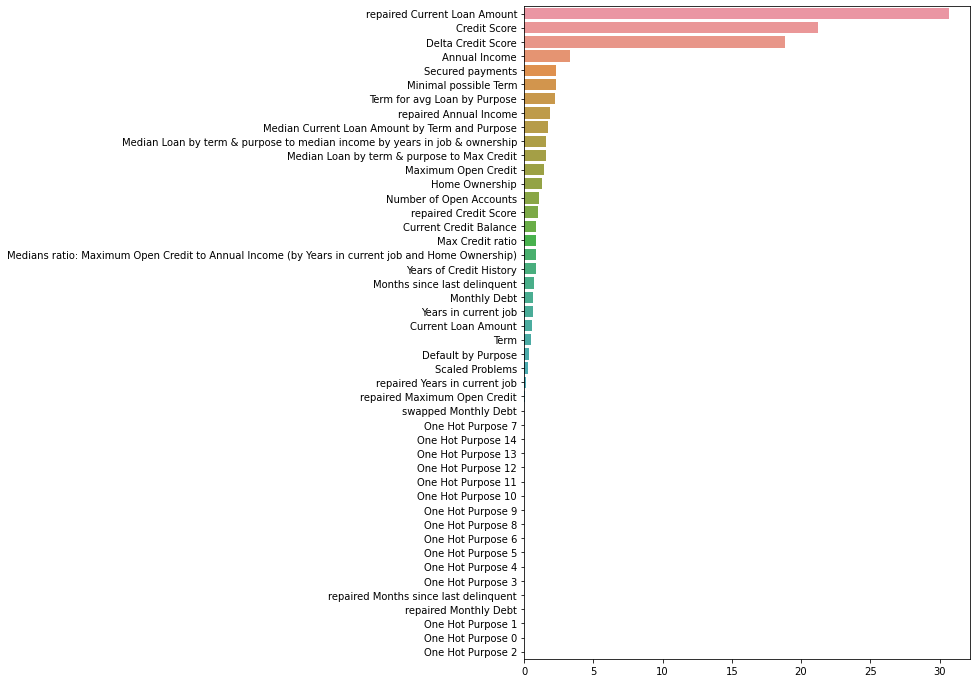

In [216]:
feat_imp = pd.Series(model.get_feature_importance(), make_model.feat_names)
feat_imp = feat_imp.sort_values(ascending=False)
plt.figure(figsize=(8, 12))
sns.barplot(feat_imp, feat_imp.index)
plt.show()

## Predictions

In [220]:
train_df = load_dataset(PATH_TRAIN, silent=True)
target_df = load_dataset(PATH_TEST, silent=True)

X_train = train_df.drop(columns='Credit Default')
y_train = train_df['Credit Default']

X_train, y_train, X_target, disbalance = prepare_data(X_train, y_train, target_df)

y_target = model.predict(X_target)


## Saving

In [218]:
with open('model.pkl', 'wb') as file:
  pickle.dump(model, file)

with open('model.pkl', 'rb') as file:
  model = pickle.load(file)

In [222]:
predict_df = pd.DataFrame(y_target.astype('int8'), columns=['Credit Default'])
predict_df.index.rename('Id', inplace=True)
predict_df.to_csv('MirzoianP_predictions.csv')